In [17]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim # For gradient descent

# This is the function that will be used to generate the truth data.
def truth_func(x1, x2):
    """
    Compute a piecewise function value based on inputs x1 and x2.
    
    Parameters:
    - x1, x2: Inputs for which the function value needs to be computed.
    
    Returns:
    - Function value based on the given conditions.
    - This function returns two values, y1 and y2.
    """
    
    # Check bounds for x1 and x2
    if not (-1 <= x1 <= 1) or not (-1 <= x2 <= 1):
        raise ValueError('Both x1 and x2 must be in the range [-1, 1]')

    # Determine the function value of y1
    if x1 >= 0:
        if x2 >= 0:
            y1 = (x1-0.5)**2 + (x2-0.5)**2
        else:
            y1 = np.sin(x1) + np.sin(x2)
    else:
        if x2 >= 0:
            y1 = 0 if x1 < -0.5 else 1
        else:
            y1 = abs(x1 + 0.5) + abs(x2 + 0.5)
    
    # Determine the function value of y2

    y2 = np.sinc(3*(x1**2) + 3*(x2**2)) * 10

    return y1, y2

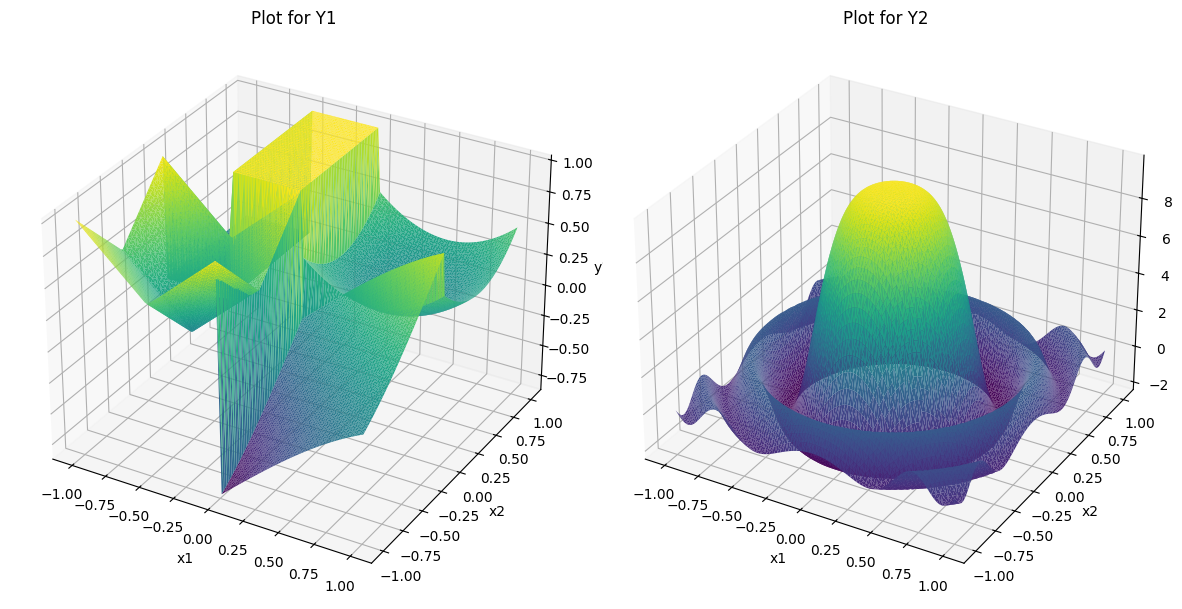

In [18]:
#Lets plot this function to see what it looks like.
# Generate the data points
x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(-1, 1, 100)

X1_points = []
X2_points = []
Y1_points = []
Y2_points = []

for x1_i in x1:
    for x2_i in x2:
        X1_points.append(x1_i)
        X2_points.append(x2_i)

        y1_i, y2_i = truth_func(x1_i, x2_i)
        Y1_points.append(y1_i)
        Y2_points.append(y2_i)


# Create the 3D plot
fig = plt.figure(figsize=(12, 6))  # Adjusting the size for better visualization

# First subplot for x1, x2, and y1
ax1 = fig.add_subplot(121, projection='3d')  # 121 means: 1 row, 2 columns, first plot
ax1.plot_trisurf(X1_points, X2_points, Y1_points, cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y1')
ax1.set_title('Plot for Y1')

# Second subplot for x1, x2, and y2
ax2 = fig.add_subplot(122, projection='3d')  # 122 means: 1 row, 2 columns, second plot
ax2.plot_trisurf(X1_points, X2_points, Y2_points, cmap='viridis')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y2')
ax2.set_title('Plot for Y2')

plt.tight_layout()  # Adjusts the plots so that they fit nicely
plt.show()

In [19]:
# Create training data for the neural network

num_train_data = 10000

# Generating random x and y values at once
x1_values = np.random.uniform(-1, 1, num_train_data)
x2_values = np.random.uniform(-1, 1, num_train_data)

# Stack them together for the input array
train_inputs = np.vstack((x1_values, x2_values)).T

# Compute the outputs using a vectorized approach
train_outputs = np.array([truth_func(x1, x2) for x1, x2 in zip(x1_values, x2_values)])



In [20]:
# Create testing data for the neural network

num_test_data = 1000 # an order of magnitude smaller than the training data

# Generating random x and y values at once
x1_values = np.random.uniform(-1, 1, num_test_data)
x2_values = np.random.uniform(-1, 1, num_test_data)

# Stack them together for the input array
test_inputs = np.vstack((x1_values, x2_values)).T

# Compute the outputs using a vectorized approach
test_outputs = np.array([truth_func(x1, x2) for x1, x2 in zip(x1_values, x2_values)])



In [21]:
# Uh oh, we have to deal with a quirk of NNs. Typically, NNs should be fed values between -1 and 1. NN will then output a value between 0 and 1.
# This is of course dependent on the activation function used. Generally, it is good practice to normalize the data before feeding it to the NN.

# Luckily, our input data is already normalized so we don't have to worry about that. The ouput data, however, is not normalized. So we need to normalize it.

def normalize_data(y1_data, y2_data, inverse=False):
    """
    Normalize the data to 0 to 1 range. Or, if inverse is True, then denormalize the data to the original range.
    
    Parameters:
    - y1_data: Data for y1.
    - y2_data: Data for y2.

    Returns:
    - Normalized data for y1 and y2.
    """
    # The input data is already in the range [-1, 1], so we just need to normalize the output data
    y1_max = 1.0
    y1_min = -1.0
    y2_max = 10.0
    y2_min = -3.0
    
    if not inverse:
        y1_data_norm = (y1_data - y1_min) / (y1_max - y1_min)
        y2_data_norm = (y2_data - y2_min) / (y2_max - y2_min)
    else:
        y1_data_norm = y1_data * (y1_max - y1_min) + y1_min
        y2_data_norm = y2_data * (y2_max - y2_min) + y2_min

    return y1_data_norm, y2_data_norm

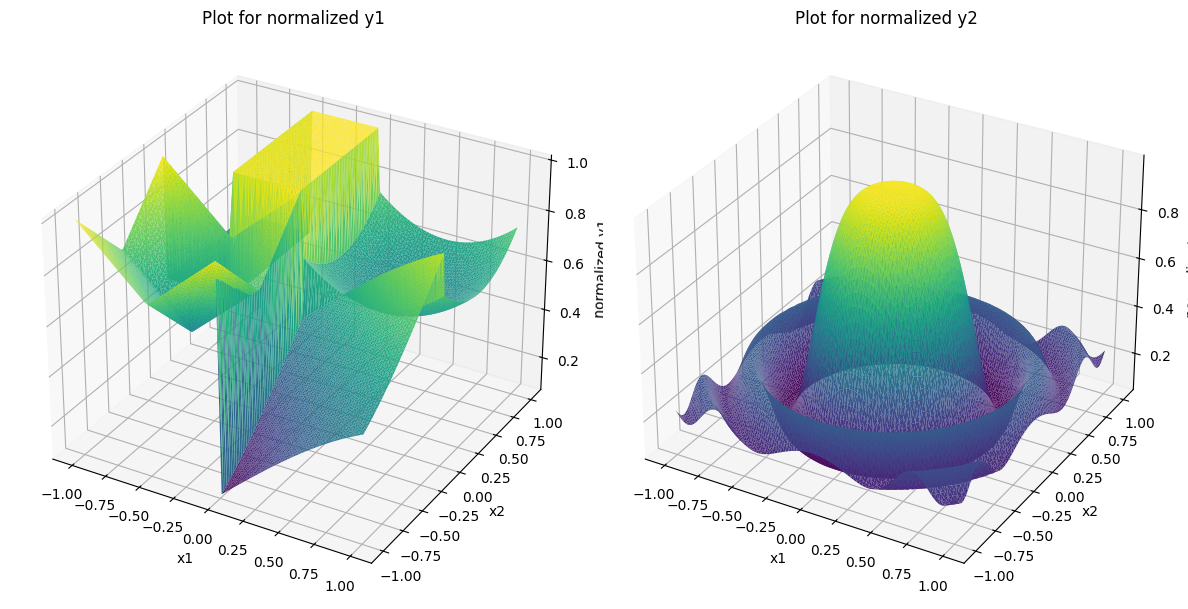

In [22]:
# for plotting purposes, we will normalize Y1_points and Y2_points as well which we plotted earlier

Y1_points_norm, Y2_points_norm = normalize_data(np.array(Y1_points), np.array(Y2_points))

# Create the 3D plot
fig = plt.figure(figsize=(12, 6))  # Adjusting the size for better visualization

# First subplot for x1, x2, and y1
ax1 = fig.add_subplot(121, projection='3d')  # 121 means: 1 row, 2 columns, first plot
ax1.plot_trisurf(X1_points, X2_points, Y1_points_norm, cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('normalized y1')
ax1.set_title('Plot for normalized y1')

# Second subplot for x1, x2, and y2
ax2 = fig.add_subplot(122, projection='3d')  # 122 means: 1 row, 2 columns, second plot
ax2.plot_trisurf(X1_points, X2_points, Y2_points_norm, cmap='viridis')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('normalized y2')
ax2.set_title('Plot for normalized y2')

plt.tight_layout()  # Adjusts the plots so that they fit nicely
plt.show()



In [23]:
# Normalize the training and testing data

train_output_1_norm, train_output_2_norm = normalize_data(train_outputs[:, 0], train_outputs[:, 1])
test_output_1_norm, test_output_2_norm = normalize_data(test_outputs[:, 0], test_outputs[:, 1])

# Stack them together for the input array
train_outputs_norm = np.vstack((train_output_1_norm, train_output_2_norm)).T
test_outputs_norm = np.vstack((test_output_1_norm, test_output_2_norm)).T

# Now that the data is normalized, we can convert to tensors
# Tensors are the arrays that PyTorch uses to store data

# Convert numpy arrays to PyTorch tensors
train_inputs_torch = torch.from_numpy(train_inputs).float()
train_outputs_torch = torch.from_numpy(train_outputs_norm).float()
test_inputs_torch = torch.from_numpy(test_inputs).float()
test_outputs_torch = torch.from_numpy(test_outputs_norm).float()

print(train_inputs_torch.shape)
print(train_outputs_torch.shape)
print(test_inputs_torch.shape)
print(test_outputs_torch.shape)


torch.Size([10000, 2])
torch.Size([10000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])


In [24]:
# Lets create a neural network to learn this function.


class DNN(nn.Module):
    def __init__(self, input_size, layer1_size, layer2_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, layer1_size)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(layer2_size, output_size)
        self.act_out = nn.Sigmoid()


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act_out(self.fc3(x))

        return x
    


In [25]:
# Define the loss (or cost) function for the neural network.
# This is the function that measures the difference between
# the predicted outputs and the actual targets, which we want to minimize.
def mse_loss(outputs, targets):
    return torch.mean((outputs - targets)**2)

In [26]:
# We need a way to evallate the DNN. We will feed it a bunch of test data and see what the average loss is from all this data.

# N.B. The testing data must be different from the training data!!! Otherwise, you will only be evaluating the DNN at places it has
# already seen, which is no bueno. Its like making a test for a student consist of entirely problems they have already had on homeworks.

def evaluate(model, test_inputs, test_outputs, loss_function):
    """
    Evaluates the average loss of a model over given test data.
    
    Parameters:
    - model: The neural network model to be evaluated.
    - test_inputs: Tensor of input data for testing.
    - test_outputs: Tensor of target output data for testing.
    - loss_function: The loss function to measure model accuracy.
    
    Returns:
    - Average loss of the model over the test data.
    """
    
    with torch.no_grad(): # disable gradient tracking since we are only evaluating for efficiency
        predictions = model(test_inputs)
        total_loss = loss_function(predictions, test_outputs)
        
    return total_loss.item() / test_inputs.size(0)


In [27]:
# Create the neural network with specified sizes for each layer
input_size = 2
layer1_size = 128
layer2_size = 64
output_size = 2

model = DNN(input_size, layer1_size, layer2_size, output_size)

# Print the model architecture to understand its structure
print(model)

# Create the optimizer for training the neural network.
# The Adam optimizer is a popular choice due to its adaptive learning rate capabilities.
# We start with a learning rate of 0.001, which is a common starting point, but this can be tuned.
optimizer = optim.Adam(model.parameters(), lr=0.001)

DNN(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (act_out): Sigmoid()
)


In [28]:
num_of_training_points = train_inputs_torch.size(0)

model_name = 'DNN_1HL128_2HL64.pt'

num_of_training_epochs = 1000 # an epoch is one pass through the entire training data

frequency_of_eval = 100 # How often to evaluate the model. Unit is steps not epochs. Sowe evaluate every 500 steps.
                    # one step is one batch of data fed to the model
evaluation_results = [] # List to store the evaluation results
min_eval_loss = np.inf # Variable to keep track of the lowest evaluation loss

total_steps = 0 # Keeps track of the total number of steps taken during training. 
                # One step is one batch of data fed to the model.
batch_size = 64 # We don't train the NN every timestep, we train it in batches. This is the size of each batch.
num_batches = num_of_training_points // batch_size 

for epoch in range(num_of_training_epochs):

    # Shuffle the data at the start of each epoch
    permutation = torch.randperm(num_of_training_points)
    training_data_inputs_shuffled = train_inputs_torch[permutation]
    training_data_outputs_shuffled = train_outputs_torch[permutation]

    for i in range(num_batches):

        # Start and end indices for the current batch
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        # Fetch the current batch
        inputs_batch = training_data_inputs_shuffled[start_idx:end_idx]
        targets_batch = training_data_outputs_shuffled[start_idx:end_idx]

        # Feed the input batch to the model
        outputs_batch = model(inputs_batch)

        # Calculate the loss for the current batch
        loss = mse_loss(outputs_batch, targets_batch)

        # Zero out any old gradients
        optimizer.zero_grad()

        # Calculate the gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        total_steps += 1

        # Evaluation
        if total_steps % frequency_of_eval == 0:
            eval_res = evaluate(model, test_inputs_torch, test_outputs_torch, mse_loss)
            evaluation_results.append(eval_res)
            print(f'Step: {total_steps} \t Evaluation loss: {eval_res}')

            if eval_res < min_eval_loss:
                min_eval_loss = eval_res
                # save to the trained_models folder
                torch.save(model.state_dict(), f'trained_models/{model_name}') 


Step: 100 	 Evaluation loss: 3.308376297354698e-05
Step: 200 	 Evaluation loss: 2.280174382030964e-05
Step: 300 	 Evaluation loss: 1.8612178042531013e-05
Step: 400 	 Evaluation loss: 1.6070526093244554e-05
Step: 500 	 Evaluation loss: 1.4225254766643048e-05
Step: 600 	 Evaluation loss: 1.2139556929469109e-05
Step: 700 	 Evaluation loss: 1.0516758076846599e-05
Step: 800 	 Evaluation loss: 9.223904460668564e-06
Step: 900 	 Evaluation loss: 8.746742270886898e-06
Step: 1000 	 Evaluation loss: 7.261674851179123e-06
Step: 1100 	 Evaluation loss: 6.615860853344202e-06
Step: 1200 	 Evaluation loss: 6.221332587301731e-06
Step: 1300 	 Evaluation loss: 5.822028033435344e-06
Step: 1400 	 Evaluation loss: 5.431029945611954e-06
Step: 1500 	 Evaluation loss: 5.2812006324529645e-06
Step: 1600 	 Evaluation loss: 5.126744043081999e-06
Step: 1700 	 Evaluation loss: 4.823986440896988e-06
Step: 1800 	 Evaluation loss: 4.666159860789776e-06
Step: 1900 	 Evaluation loss: 4.64125070720911e-06
Step: 2000 	 Eva

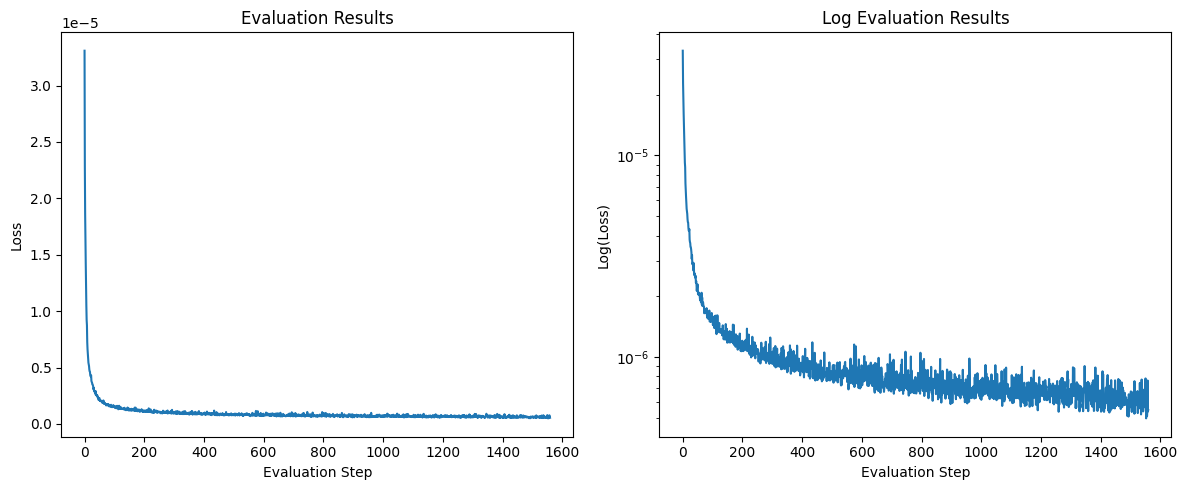

In [29]:
# Lets plot the loss function over time to see how it changes.

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the regular results
axes[0].plot(evaluation_results)
axes[0].set_xlabel('Evaluation Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Evaluation Results')

# Plot the log of the results on the second subplot
# (Adding 1 to avoid log(0) if you have zero values in your results)
axes[1].plot(evaluation_results)
axes[1].set_yscale('log')
axes[1].set_xlabel('Evaluation Step')
axes[1].set_ylabel('Log(Loss)')
axes[1].set_title('Log Evaluation Results')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()